In [1]:
%matplotlib inline

In [2]:
import matplotlib
from matplotlib import pyplot as plt

In [3]:
import sys
from IPython.display import clear_output

In [4]:
from qutip import *
import numpy as np
from scipy.constants import *
from scipy import sqrt, log, pi

In [5]:
font = {'size'   : 15}

matplotlib.rc('font', **font)

In [6]:
def format_time(time_sec):
    hours = time_sec//3600
    minutes = (time_sec%3600)//60
    seconds = time_sec - hours*3600 - minutes*60
    return hours, minutes, seconds

# Описание системы

### Параметры, гамильтониан, возмущения

In [18]:
N = 20

#Unitary evolution parameters
omega_r = 1 * 2*pi
omega_q = .6 * 2*pi
A = 0.0005
B = 0.1 
g=.0025*omega_r
omega_f = 0.9*2*pi
delta = 0

#Dissipation
kappa=0.01
gamma_deph = 0.01
gamma_rel = 0.01
thermal_omega = 0.1*omega_r

def a():
    return destroy(N)

def build_H_undr(omega_q = 0.6*omega_r, delta = 0):
    H_q = tensor(identity(N), sigmaz()*sqrt(omega_q**2+delta**2)/2)
    H_r = tensor(omega_r*(1/2+a().dag()*a()), identity(2))
    H_int = g*tensor(a() + a().dag(), delta/sqrt(omega_q**2+delta**2)*sigmaz()-
                     omega_q/sqrt(omega_q**2+delta**2)*sigmax())
    return H_q+H_r+H_int

def build_H_undr_test(omega_q = 0.6*omega_r, delta = 0):
    H_r = tensor((1/2 + a().dag()*a())*omega_r, identity(2))
    H_q = tensor(identity(N), sigmaz()*omega_q/2+sigmax()*delta/2)
    H_int = g*tensor(a()+a().dag(), sigmax())
    return H_r+H_q+H_int

##Driving
def build_H_dr_fl():
    return [A*tensor(destroy(N)+create(N), identity(2)), "np.sin(omega_f*t)"]

def build_H_dr(t_on=0, t_off=1000):
    return [A*tensor(destroy(N)+create(N), identity(2)),
            "np.sin(omega_f*t)/(1+np.exp(-t+%d))/(1+np.exp(t-%d))"%(t_on, t_off)]

def build_H_dr_q(t_on=200, t_off=231):
    return [B*tensor(identity(N), sigmax()), "np.sin(omega_f_q*t)/(1+np.exp(-t+%d))/(1+np.exp(t-%d))"%(t_on, t_off)]

##

def build_H():
    return [build_H_undr(), build_H_dr()]

def n_av(omega):
    return 1/(np.exp(omega/thermal_omega)-1)
def build_c_ops(omega_q=0.1*omega_r, delta=0):
    return [tensor(sqrt(kappa*(n_av(omega_r)))*create(N), identity(2)),
            tensor(sqrt(kappa*(n_av(omega_r)+1))*destroy(N), identity(2)),
            tensor(identity(N), sqrt(gamma_rel*(n_av(sqrt(omega_q**2+delta**2))+1))*sigmam()),
            tensor(identity(N), sqrt(gamma_rel*n_av(sqrt(omega_q**2+delta**2)))*sigmap()),
            tensor(identity(N), sqrt(gamma_deph)*sigmaz())]

### Расчет стационарных состояний

In [15]:
def evals(omega_q = 0.6*omega_r, delta = 0):
    return build_H_undr(omega_q, delta).eigenenergies()
def evecs(omega_q = 0.6*omega_r, delta = 0):
    return build_H_undr(omega_q, delta).eigenstates()[1]

In [16]:
(evals(omega_q=0.2*omega_r)[1]-evals(omega_q=0.2*omega_r)[0])/0.2/omega_r

0.99998697926556557

### Отслеживание параметров

In [17]:
def description(comment):
    params = {}
    params["omega_r"] = omega_r
    params["omega_q"] = omega_q/omega_r
    params["A"] = A
    params["B"] = B
    params["g"] = g/omega_r
    params["N"] = N
    params["kappa"] = kappa
    params["gamma_deph"] = gamma_deph
    params["gamma_rel"] = gamma_rel
    params["comment"] = comment
    return params

# Дисперсионное считывание

In [145]:
## Test
opts = Options()
opts.nsteps = 5000

args={'omega_f':(evals()[2]-evals()[0]), "omega_f_q":(evals()[1]-evals()[0])}

A = 0.02
B=0.1
g=0.1
N = 25
Ts = np.linspace(0, 1000, 800)
kappa=0.08

outp1 = mesolve([build_H_undr(), build_H_dr()], 
                 evecs()[0],  Ts,\
                    build_c_ops(), [tensor(num(N), identity(2)), tensor(identity(N), sigmam().dag()*sigmam())],
                    args,  progress_bar=True, options=opts)

10.0%. Run time:  18.60s. Est. time left: 00:00:02:47
20.0%. Run time:  37.63s. Est. time left: 00:00:02:30
30.0%. Run time:  56.52s. Est. time left: 00:00:02:11
40.0%. Run time:  76.31s. Est. time left: 00:00:01:54
50.0%. Run time: 102.93s. Est. time left: 00:00:01:42
60.0%. Run time: 131.97s. Est. time left: 00:00:01:27
70.0%. Run time: 162.76s. Est. time left: 00:00:01:09
80.0%. Run time: 193.55s. Est. time left: 00:00:00:48
90.0%. Run time: 225.55s. Est. time left: 00:00:00:25
Total run time: 253.46s


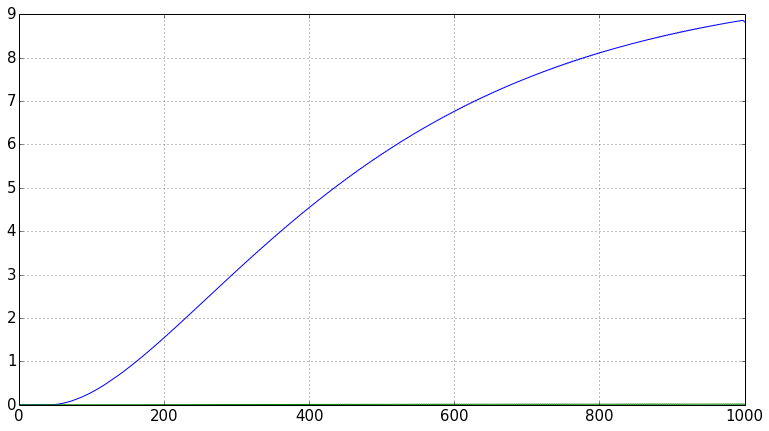

In [146]:
plt.plot(Ts, outp1.expect[0], label = r"$\langle N \rangle$")
plt.plot(Ts, outp1.expect[1], label = r"$|\langle \psi\ | \uparrow \rangle|^2$")
plt.grid()
# plt.legend(loc = "upper left", fontsize=20)
plt.gcf().set_size_inches(13,7)

In [203]:

args={'omega_f':(evals()[2]-evals()[0]), "omega_f_q":omega_q}

N=25
gamma = 0
Ts = np.linspace(0, 1000, 800)
outp2 = mesolve([build_H_undr(), build_H_dr(200, 1200), build_H_dr_q()], evecs()[0],  Ts,
                    build_c_ops() , [tensor(num(N), identity(2)), 
                    tensor(identity(N), sigmam().dag()*sigmam())],
                    args,  progress_bar=True, options=opts)

10.0%. Run time:   8.72s. Est. time left: 00:00:01:18
20.0%. Run time:  18.04s. Est. time left: 00:00:01:12
30.0%. Run time:  44.38s. Est. time left: 00:00:01:43
40.0%. Run time:  67.44s. Est. time left: 00:00:01:41
50.0%. Run time:  90.02s. Est. time left: 00:00:01:30
60.0%. Run time: 112.62s. Est. time left: 00:00:01:15
70.0%. Run time: 135.42s. Est. time left: 00:00:00:58
80.0%. Run time: 159.22s. Est. time left: 00:00:00:39
90.0%. Run time: 182.90s. Est. time left: 00:00:00:20
Total run time: 205.70s


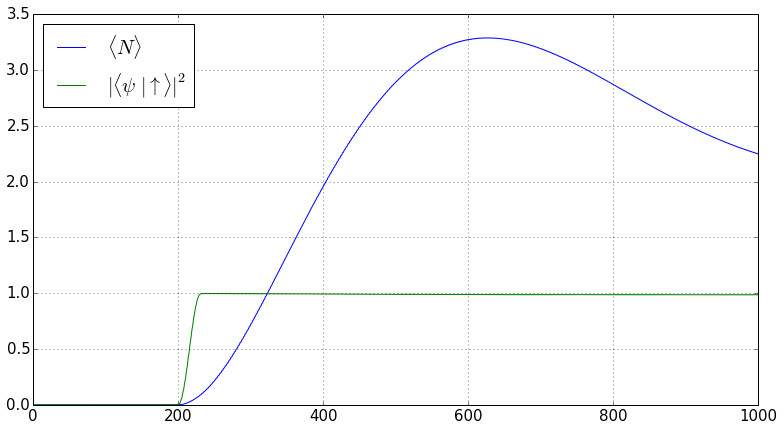

In [204]:
plt.plot(Ts, outp2.expect[0], label = r"$\langle N \rangle$")
plt.plot(Ts, outp2.expect[1], label = r"$|\langle \psi\ | \uparrow \rangle|^2$")
plt.grid()
plt.legend(loc = "upper left", fontsize=20)
plt.gcf().set_size_inches(13,7)

# Двухтоновая спектроскопия

In [284]:
build_H_dr_q(1, 1500)[1]

'np.sin(omega_f_q*t)/(1+np.exp(-t+1))/(1+np.exp(t-1500))'

In [309]:
opts = Options(rhs_reuse=True)
opts.nsteps=5000

args={'omega_f':(evals()[2]-evals()[0]), "omega_f_q":0.5*(evals()[1]-evals()[0])}

N=8
kappa = 0
gamma = 0
A = 0.005
B = 0.1
Ts = np.linspace(0, 700, 800)

def task(omega_f_q):
    args["omega_f_q"] = omega_f_q
    return mesolve([build_H_undr(), build_H_dr(1, 1500), build_H_dr_q(1, 1500)], evecs()[0],  Ts,
                    [] , [tensor(num(N), identity(2)), 
                    tensor(identity(N), sigmam().dag()*sigmam())],
                    args, options=opts)

parallel_map(task, ((evals()[1]-evals()[0]), 0.5*(evals()[1]-evals()[0])), progress_bar=True)

50.0%. Run time:  16.28s. Est. time left: 00:00:00:16
100.0%. Run time:  16.71s. Est. time left: 00:00:00:00
Total run time:  16.75s


[Result object with sesolve data.
 --------------------------------
 expect = True
 num_expect = 2, num_collapse = 0, Result object with sesolve data.
 --------------------------------
 expect = True
 num_expect = 2, num_collapse = 0]

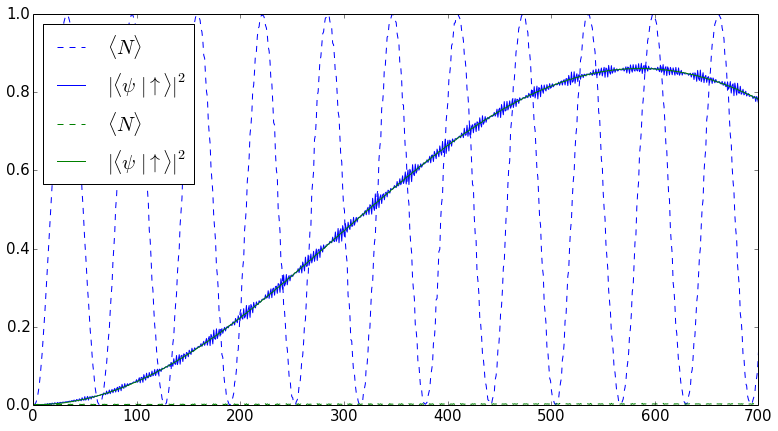

In [308]:
plt.plot(Ts, _[0].expect[1], "b--", label = r"$\langle N \rangle$")
plt.plot(Ts, _[0].expect[0], "b", label = r"$|\langle \psi\ | \uparrow \rangle|^2$")
plt.plot(Ts, _[1].expect[1], "g--", label = r"$\langle N \rangle$")
plt.plot(Ts, _[1].expect[0], "g", label = r"$|\langle \psi\ | \uparrow \rangle|^2$")
plt.grid()
plt.grid()
plt.legend(loc = "upper left", fontsize=20)
plt.gcf().set_size_inches(13,7)

In [477]:
opts = Options()
opts.rhs_reuse = True

N=8
kappa = 0
gamma = 0
Ts = np.linspace(0, 700, 800)
opts.nsteps = 5000

deltas = np.linspace(0.9*omega_r, 1.1*omega_r, 50)
omega_f_qs = np.linspace(0.85*omega_r, 1.1*omega_r, 50)

def parallel_task(delta):
    return mesolve([build_H_undr(omega_q = 0.2*omega_r, delta=delta), 
                        build_H_dr(0, 700), build_H_dr_q(0, 700)], evecs()[0],  Ts,
                        [] , [tensor(num(N), identity(2)), 
                        tensor(identity(N), sigmam().dag()*sigmam())],
                        args, options=opts).expect[0][-1]

def calculate():
    results = []
    for idx, omega_f_q in enumerate(omega_f_qs):
        print("\r%d%%"%round(idx/len(omega_f_qs)*100, 0), end='') 
        args["omega_f_q"] = omega_f_q
        results.append(parallel_map(parallel_task, deltas))   
    return results


results = calculate()

98%

In [479]:
data2 = np.zeros((len(omega_f_qs), 2*len(deltas)-1))
for idx, result in enumerate(results):
    for idx2 in range(0,len(deltas)):
        data2[idx, idx2+len(deltas)-1] = result[idx2]
#         data2[idx, len(deltas)-idx2-1] = result[idx2]

In [481]:
data2 = np.zeros((len(omega_f_qs), len(deltas)))
for idx, result in enumerate(results):
    for idx2 in range(0,len(deltas)):
        data2[idx, idx2] = result[idx2]

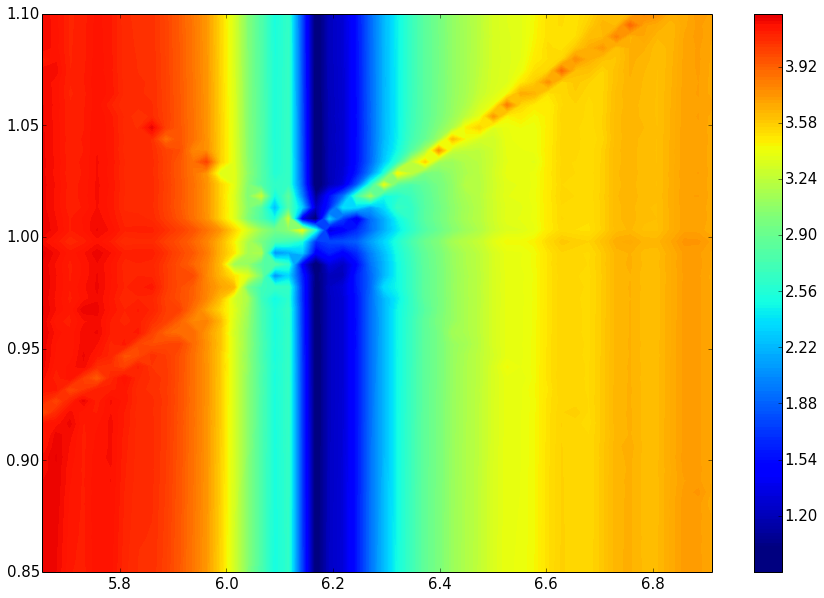

In [494]:
XX, YY = np.meshgrid(deltas, omega_f_qs/omega_r)
plt.contourf(XX, YY, data2, 200, norm=MidpointNorm(3, vmin=1, vmax = 4.5))#, cmap='RdBu_r')
plt.gcf().set_size_inches(15,10)
plt.colorbar()

(0.9, 1.1)

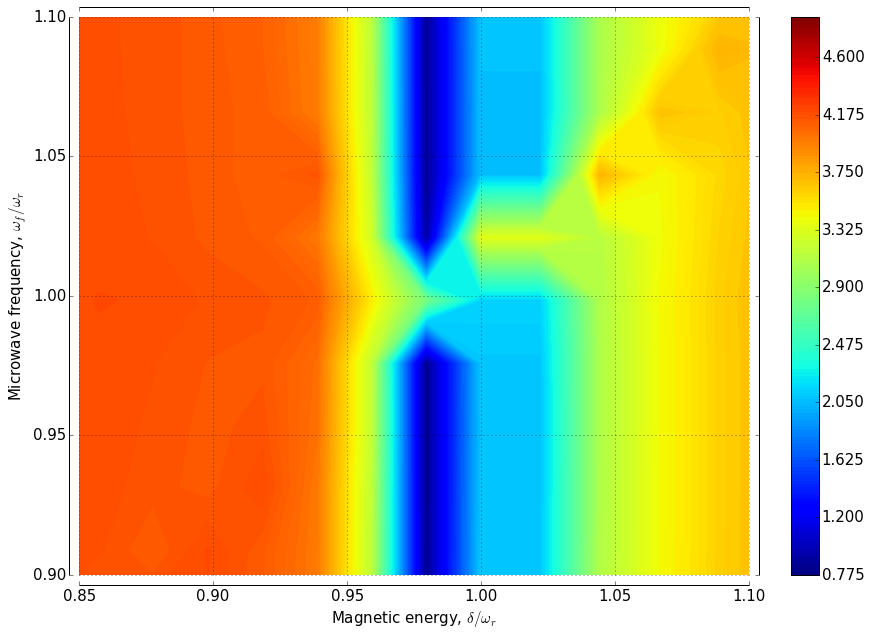

In [476]:
XX, YY = np.meshgrid(np.concatenate((-deltas2[1:][::-1],deltas2))/omega_r, omega_f_qs/omega_r)
plt.contourf(XX, YY, data2, 200)#, norm=MidpointNorm(4.5, vmin=3.8, vmax = 5))#, cmap='RdBu_r')
plt.gcf().set_size_inches(15,10)
plt.colorbar()
dict(plt.gca().spines.items())["left"].set_position(('outward', 10))
dict(plt.gca().spines.items())["bottom"].set_position(('outward', 10))
dict(plt.gca().spines.items())["top"].set_position(('outward', 10))
dict(plt.gca().spines.items())["right"].set_position(('outward', 10))
plt.xlabel(r"Magnetic energy, $\delta/\omega_r$")
plt.ylabel("Microwave frequency, $\omega_f/\omega_r$")
plt.grid()
plt.xlim(0.85,1.1)
plt.ylim(0.9, 1.1)

In [467]:
import pickle
with open("two_tone2.pkl", "w+b") as f:
    pickle.dump((np.concatenate((-deltas2[1:][::-1],deltas2)), omega_f_qs/omega_r, data2), f)

# Квазипересечение

In [481]:
import time

opts = Options()
opts.rhs_reuse = True
opts.nsteps = 1e4
rhs_clear()

args={}

N=3
kappa = 6.5e-4
gamma_rel = .1
gamma_deph =.1
g=0.03*omega_r
A = 1e-5
omega_q = 0.2*omega_r

deltas = np.linspace(-1.5*omega_r, -.5*omega_r, 90)
omega_fs = np.linspace(0.998*omega_r, omega_r*1.002, 90)

def parallel_task(omega_f, H, delta):
    
    args["omega_f"] = omega_f
    T = 2*pi/args["omega_f"]
   
    U = propagator([H, build_H_dr(-100, 1e3)], T, [], args, options=opts)
    psi_st = propagator_steadystate(U)
    return expect(tensor(a(), identity(2)), psi_st) -\
               expect(tensor(a(), identity(2)), evecs(omega_q=omega_q, delta=delta)[0])

def calculate():
    results = []
    time_start = time.time()
    print(description("qubit_anticrossings"))
    print("\r%d%%"%0, "Time left: ?", end='') 

    for idx, delta in enumerate(deltas):
        
        H = liouvillian(build_H_undr(omega_q=omega_q, delta=delta), build_c_ops_new(omega_q=omega_q, delta=delta))
        
        result = parallel_map(parallel_task, omega_fs, task_args = (H, delta))
        results.append(result)
        
        percents_done = round((idx+1)/len(deltas)*100, 2)
        time_left = format_time((time.time()-time_start)*(100-percents_done)/percents_done)
        print("\r%.2f%%"%percents_done, "Time left: ", "%d h, %d m, %.1f s"%(time_left)
              , "Elapsed time: %d h, %d m, %.1f s"%(format_time((time.time()-time_start))), end = "") 
    print("\nElapsed time: %d h, %d m, %.1f s"%(format_time((time.time()-time_start))))
    return results


results = calculate()

{'A': 1e-05, 'B': 0.1, 'gamma_rel': 0.1, 'gamma_deph': 0.1, 'kappa': 0.00065, 'g': 0.03, 'omega_r': 6.283185307179586, 'comment': 'qubit_anticrossings', 'omega_q': 0.2, 'N': 3}
100.00% Time left:  0 h, 0 m, 0.0 s Elapsed time: 0 h, 54 m, 6.6 s
Elapsed time: 0 h, 54 m, 6.6 s


In [482]:
data2 = np.zeros((len(omega_fs),len(deltas))).T# 2*len(deltas)-1)).T
for idx, result in enumerate(results):
    for idx2 in range(0,len(omega_fs)):
        data2[idx, idx2] = abs(result[idx2])
#         data2[len(deltas)-1-idx, idx2] = abs(result[idx2])

In [493]:
freqs1 = []
freqs2 = []
X = -np.linspace(0.5*omega_r, 1.5*omega_r, 50)[::1]
g=0.03*omega_r
for delta in X:
    vals = evals(omega_q=0.2*omega_r, delta=delta)
    freqs1.append(vals[1]-vals[0])
    freqs2.append(vals[2]-vals[0])

In [494]:
np.max(data2.T)

0.014276757042306524

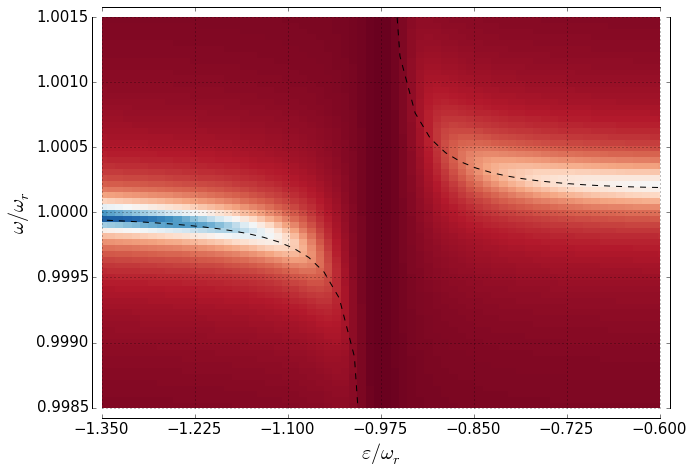

In [523]:
XX, YY = np.meshgrid(deltas/omega_r, omega_fs/omega_r)
ab = plt.pcolor(XX, YY, data2.T*1.01, cmap="RdBu", vmax = 0.015, vmin=0)#, norm=MidpointNorm(0.01, vmin=0, vmax = 0.022))#, cmap='RdBu_r')
plt.plot(X/omega_r, np.array(freqs1)/omega_r, "--", color="black")
plt.plot(X/omega_r, np.array(freqs2)/omega_r, "--", color="black")
plt.gcf().set_size_inches(10,7)
dict(plt.gca().spines.items())["left"].set_position(('outward', 10))
dict(plt.gca().spines.items())["bottom"].set_position(('outward', 10))
dict(plt.gca().spines.items())["top"].set_position(('outward', 10))
dict(plt.gca().spines.items())["right"].set_position(('outward', 10))


plt.xticks(np.linspace(-1.35, -.6, 7))
plt.xlim(-1.35, -.6)
plt.ylim(0.9985, 1.0015)
plt.grid()
plt.ylabel("$\omega/\omega_r$", fontsize=20)
plt.xlabel(r"$\varepsilon/\omega_r$", fontsize=20)

plt.gca().get_yaxis().get_major_formatter().set_useOffset(False)

# fig = plt.gcf()
# axs = fig.add_axes([.93, .12, .02,.7])
# cb = plt.colorbar(ab, cax = axs, ticks = np.linspace(0, 0.02, 5))
# ax = cb.ax
# ax.text(0,1.075,r'$\langle \hat a \rangle_{st. s.}$',rotation=0, fontsize = 20)

In [418]:
import pickle
with open("anticrossing_big_coupling2.pkl", "w+b") as f:
    pickle.dump((np.concatenate((-deltas[::-1],deltas[1:]))/omega_r, omega_fs/omega_r, data2, description("anticrossing_big_coupling")), f)

In [250]:
import pickle
with open("anticrossing_big_coupling.pkl", "r+b") as f:
    loaded = pickle.load(f)

In [251]:
loaded[-1]

{'A': 1e-05,
 'B': 0.1,
 'N': 3,
 'comment': 'anticrossing_big_coupling',
 'g': 0.03,
 'gamma_deph': 0.007,
 'gamma_rel': 0.01,
 'kappa': 0.0005,
 'omega_q': 0.2,
 'omega_r': 6.283185307179586}

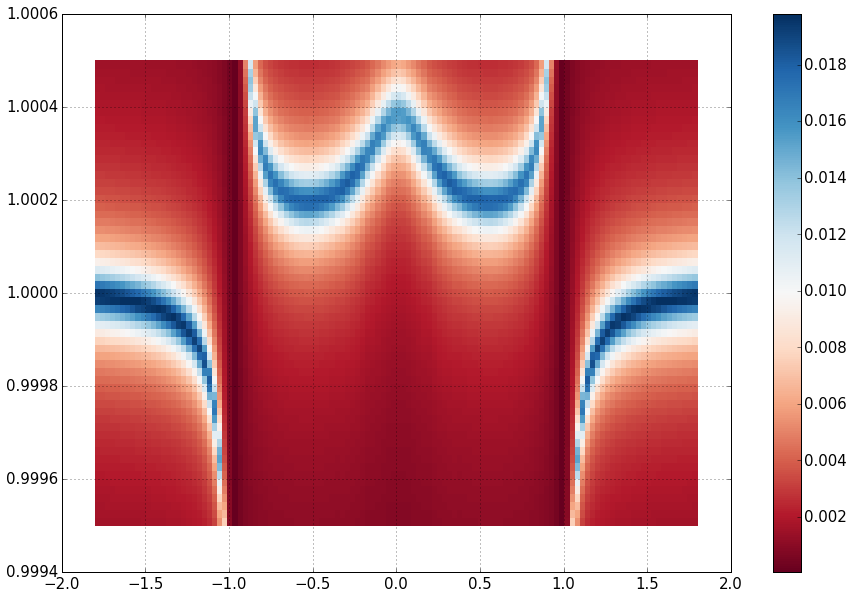

In [254]:
XX, YY = np.meshgrid(loaded[0], loaded[1])
plt.pcolor(XX, YY, loaded[2].T, cmap="RdBu")#, 200, cmap="RdBu")#, norm=MidpointNorm(3, vmin=1, vmax = 4.5))#, cmap='RdBu_r')
# plt.plot(X/omega_r, np.array(freqs1)/omega_r, "--")
# plt.plot(X/omega_r, np.array(freqs2)/omega_r, "--")
plt.gcf().set_size_inches(15,10)
# plt.xlim(.96, 1)
# plt.ylim(0.997, 1.003)
plt.colorbar()
plt.grid()

In [97]:
rm -f *pyx

## Linewidth

### Propagator (evolution operator)

In [80]:
evals(omega_q=0.2*omega_r, delta=0.97975*omega_r)/omega_r

array([ -2.55351152e-05,   9.98551887e-01,   1.00135208e+00,
         1.99804195e+00,   2.00200607e+00,   3.00007355e+00])

In [83]:
(evals(omega_q=0.2*omega_r, delta=0.97975*omega_r)[2]-evals(omega_q=0.2*omega_r, delta=0.97975*omega_r)[0])/omega_r

1.0013776140938615

In [50]:
expect(tensor(a(), identity(2)), evecs(omega_q=0.2*omega_r, delta=0)[0])

0j

In [82]:
N=3
kappa = 6.5e-4
gamma_rel = .1
gamma_deph =.1
g=0.03*omega_r
A = 1e-5
omega_q = 0.1*omega_r
thermal_omega = 5e-1*omega_r

T_end = 8000
Ts = np.linspace(0, T_end, 800)
opts = Options()
opts.nsteps = 5000
opts.rhs_reuse = True
rhs_clear()

args={}

omega_fs = np.linspace(0.9995*omega_r, omega_r*1.0005, 50)


def task(omega_f):
    args["omega_f"]=omega_f
    T = 2*pi/omega_f 
    H = liouvillian(build_H_undr(omega_q=0.2*omega_r, delta=coeff*omega_r), c_ops_new)
   
    U = propagator([H, build_H_dr(-100, 1e3)], T, [], args, options=opts)
    psi_st = propagator_steadystate(U)
    
    return abs(expect(tensor(a(), identity(2)), psi_st) -\
               expect(tensor(a(), identity(2)), evecs(omega_q=0.2*omega_r, delta=coeff*omega_r)[0]))

coeff = -0.5
c_ops_new = build_c_ops(omega_q=0.2*omega_r, delta = coeff*omega_r)
outputs = parallel_map(task, omega_fs, progress_bar=True, num_cpus = 2)
coeff = -0.2
c_ops_new = build_c_ops(omega_q=0.2*omega_r, delta = coeff*omega_r)#_new(omega_q=0.2*omega_r, delta = coeff*omega_r)
outputs1 = parallel_map(task, omega_fs, progress_bar=True, num_cpus = 2)
coeff = -.1
c_ops_new = build_c_ops(omega_q=0.2*omega_r, delta = coeff*omega_r)#_new(omega_q=0.2*omega_r, delta = coeff*omega_r)
outputs2 = parallel_map(task, omega_fs, progress_bar=True, num_cpus = 2)
coeff = -0.05
c_ops_new = build_c_ops(omega_q=0.2*omega_r, delta = coeff*omega_r)#_new(omega_q=0.2*omega_r, delta = coeff*omega_r)
outputs3 = parallel_map(task, omega_fs, progress_bar=True, num_cpus = 2)
coeff = 0
c_ops_new = build_c_ops(omega_q=0.2*omega_r, delta = coeff*omega_r)#_new(omega_q=0.2*omega_r, delta = coeff*omega_r)
outputs4 = parallel_map(task, omega_fs, progress_bar=True, num_cpus = 2)

10.0%. Run time:   5.13s. Est. time left: 00:00:00:46
20.0%. Run time:   6.61s. Est. time left: 00:00:00:26
30.0%. Run time:   8.55s. Est. time left: 00:00:00:19
40.0%. Run time:  10.06s. Est. time left: 00:00:00:15
50.0%. Run time:  11.71s. Est. time left: 00:00:00:11
60.0%. Run time:  13.34s. Est. time left: 00:00:00:08
70.0%. Run time:  15.32s. Est. time left: 00:00:00:06
80.0%. Run time:  16.76s. Est. time left: 00:00:00:04
90.0%. Run time:  18.60s. Est. time left: 00:00:00:02
100.0%. Run time:  19.99s. Est. time left: 00:00:00:00
Total run time:  20.08s
10.0%. Run time:   3.93s. Est. time left: 00:00:00:35
20.0%. Run time:   5.28s. Est. time left: 00:00:00:21
30.0%. Run time:   7.19s. Est. time left: 00:00:00:16
40.0%. Run time:   8.70s. Est. time left: 00:00:00:13
50.0%. Run time:  10.30s. Est. time left: 00:00:00:10
60.0%. Run time:  12.05s. Est. time left: 00:00:00:08
70.0%. Run time:  13.62s. Est. time left: 00:00:00:05
80.0%. Run time:  15.10s. Est. time left: 00:00:00:03
90.

(0.9995, 1.0005)

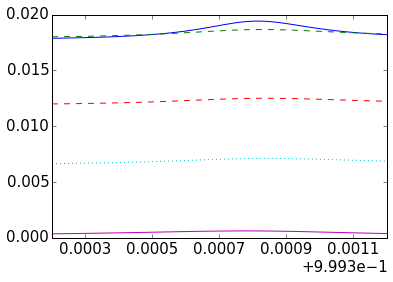

In [83]:
plt.plot(omega_fs/omega_r, outputs, '-')
plt.plot(omega_fs/omega_r, outputs1, '--')
plt.plot(omega_fs/omega_r, outputs2, '--')
plt.plot(omega_fs/omega_r, outputs3, ':')
plt.plot(omega_fs/omega_r, outputs4, '-')

# gamma_deph = 0
plt.xlim(.9995,1.0005)
# plt.ylim(0, 0.015)

(0.9995, 1.0005)

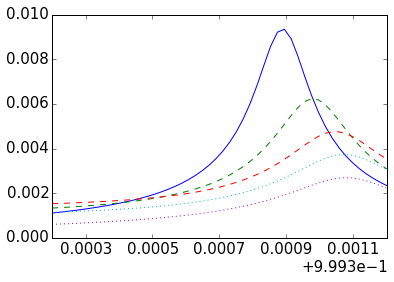

In [77]:
plt.plot(omega_fs/omega_r, outputs, '-')
plt.plot(omega_fs/omega_r, outputs1, '--')
plt.plot(omega_fs/omega_r, outputs2, '--')
plt.plot(omega_fs/omega_r, outputs3, ':')
plt.plot(omega_fs/omega_r, outputs4, ':')

# gamma_deph = 0
plt.xlim(.9995,1.0005)
# plt.ylim(0, 0.015)

In [58]:
expect(tensor(a(), identity(2)), evecs(omega_q=0.2*omega_r, delta=0.3*omega_r)[0])

(0.02497432224525246+0j)

(0.9995, 1.0005)

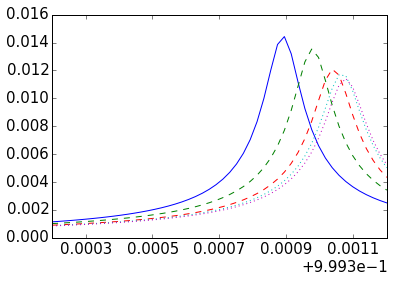

In [73]:
plt.plot(omega_fs/omega_r, outputs, '-')
plt.plot(omega_fs/omega_r, outputs1, '--')
plt.plot(omega_fs/omega_r, outputs2, '--')
plt.plot(omega_fs/omega_r, outputs3, ':')
plt.plot(omega_fs/omega_r, outputs4, ':')

# gamma_deph = 0
plt.xlim(.9995,1.0005)
# plt.ylim(0, 0.015)

(0.997, 1.003)

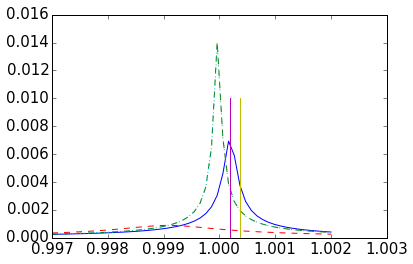

In [505]:
plt.plot(omega_fs/omega_r, outputs, '-')
plt.plot(omega_fs/omega_r, outputs1, '--')
plt.plot(omega_fs/omega_r, outputs2, '--')
plt.plot(omega_fs/omega_r, outputs3, ':')
# plt.plot(omega_fs/omega_r, outputs4, ':')
plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)
plt.plot([(evals(omega_q=0.2*omega_r, delta=.6*omega_r)[2]\
           -evals(omega_q=0.2*omega_r, delta=.6*omega_r)[0])/omega_r]*2, [0, 0.01])

plt.plot([(evals(omega_q=0.2*omega_r)[2]\
           -evals(omega_q=0.2*omega_r)[0])/omega_r]*2, [0, 0.01])
plt.xlim(.997,1.003)

In [270]:
expect(tensor(a(), identity(2)), evecs(omega_q=0.2*omega_r, delta=coeff*omega_r)[0])

(0.045409590307734726+0j)

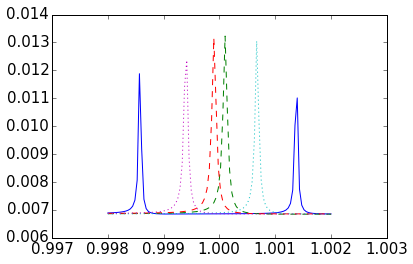

In [48]:
plt.plot(omega_fs/omega_r, outputs, '-')
plt.plot(omega_fs/omega_r, outputs1, '--')
plt.plot(omega_fs/omega_r, outputs2, '--')
plt.plot(omega_fs/omega_r, outputs3, ':')
plt.plot(omega_fs/omega_r, outputs4, ':')
# plt.ylim(0.006, 0.008)

In [30]:
rm -f *.pyx

## Climbing JC ladder

In [62]:
projections = []
for state in states:
    projection = []
    for system_state in result.states:
        obj = state.dag()*system_state
        projection.append(abs(obj.data.toarray()[0,0])**2)
    projections.append(projection)

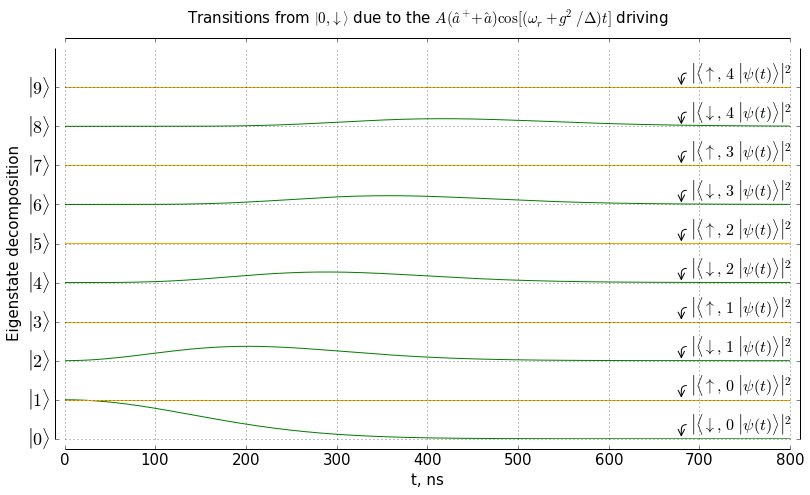

In [367]:
for idx, projection in enumerate(projections[:10]):
    plt.plot(Ts, np.array(projection)+idx, "green" if idx%2==0 else "orange")
    annotation = r'$\left|\left.\langle %s,\ %d\ \right |\psi(t)\rangle\right|^2$'%(\
                r"\uparrow" if idx%2!=0 else r"\downarrow", idx//2)
    plt.annotate(annotation,\
                     (680, idx), \
                     (690, idx+0.2), \
                     arrowprops={'arrowstyle':'->', \
                    'connectionstyle':"angle,angleA=0,angleB=90,rad=5"},  fontsize=16)
    

dict(plt.gca().spines.items())["left"].set_position(('outward', 10))
dict(plt.gca().spines.items())["bottom"].set_position(('outward', 10))
dict(plt.gca().spines.items())["top"].set_position(('outward', 10))
dict(plt.gca().spines.items())["right"].set_position(('outward', 10))
plt.ylim(0, 10)
plt.xlabel("t, ns", fontsize=15)
plt.ylabel("Eigenstate decomposition", fontsize=15)
plt.yticks(range(0, 10), [r'$\left|%d\rangle\right.$'%n for n in range(0,10)], fontsize=18)
plt.gcf().set_size_inches(13,7)
plt.title(r"Transition from $\left|0,\downarrow\right\rangle$ due to the $A(\hat{a}^+\! +\hat a)\cos[(\omega_r+g^2/\Delta) t]$ driving",
          position=(0.5, 1.05), fontsize=15)
plt.grid()

## Q-R decoherence

### New dissipators

In [11]:
def build_c_ops_new(omega_q = .6*omega_r, delta=0):
    def abs_sq(qobj):
        return qobj.dag()*qobj
    c_ops = []
    c_op_kappa_base = tensor(a().dag()+a(), identity(2))
    c_op_gamma_rel_base = tensor(identity(N), sigmax())
    c_op_gamma_deph_base = tensor(identity(N), sigmaz())
    c_op_gamma_deph_jj = 0
    
    evecs_ = evecs(omega_q, delta)
    for i in range(0, 2*N):
        for j in range(0, 2*N):
            if j>i:
                Gamma_ij_kappa = sqrt(kappa)*c_op_kappa_base.matrix_element(evecs_[i].dag(), evecs_[j])
                Gamma_ij_gamma_rel = sqrt(gamma_rel)*c_op_gamma_rel_base.matrix_element(evecs_[i].dag(), evecs_[j])
                
                if Gamma_ij_kappa != 0:
                    c_ops.append(Gamma_ij_kappa*evecs_[i]*evecs_[j].dag())
                if Gamma_ij_gamma_rel != 0:
                    c_ops.append(Gamma_ij_gamma_rel*evecs_[i]*evecs_[j].dag())
            if j != i:
                Gamma_ij_gamma_deph=sqrt(gamma_deph)*c_op_gamma_deph_base.matrix_element(evecs_[i].dag(), evecs_[j])
                if Gamma_ij_gamma_deph!=0:
                    c_ops.append(Gamma_ij_gamma_deph*evecs_[i]*evecs_[j].dag())
            if j == i:
                Gamma_ij_gamma_deph = sqrt(gamma_deph) * c_op_gamma_deph_base.matrix_element(evecs_[i].dag(), evecs_[i])
#                 if Gamma_ij_gamma_deph != 0:
#                     c_op_gamma_deph_jj+= Gamma_ij_gamma_deph*evecs_[i]*evecs_[i].dag()
    if c_op_gamma_deph_jj!=0:
        c_ops.append(c_op_gamma_deph_jj)
    return c_ops

# Parity

In [93]:
P1 = (log(-1+0j)*(tensor(a().dag()*a(),identity(2)))).expm()

In [158]:
P2 = (log(-1+0j)*(tensor(identity(N), sigmam()*sigmap()))).expm()

In [117]:
g=0.5*omega_r

In [118]:
for i in range(0, 10):
    print(expect(P1*P2, evecs(omega_q=omega_r)[i]))

-0.9999999999999999
1.0000000000000002
-1.0
1.0000000000000002
1.0000000000000002
-0.9999999999999999
-1.0000000000000004
1.0
-1.0
1.0


In [160]:
g=0.5*omega_r

In [166]:
state = tensor(a().dag()+a(), identity(2))*evecs(omega_q=omega_r)[0]
print(expect(P1*P2, evecs(omega_q=omega_r)[0]))
expect(P1*P2, state)

-1.0000000000000002


1.4533896462015705

# Single qubit

In [84]:
font = {'size'   : 20}

matplotlib.rc('font', **font)

In [85]:
omega_q = 2*pi * 1

In [86]:
from matplotlib import cm

In [87]:
H = omega_q/2 * sigmaz()

In [92]:
gamma_rel = 0.1
gamma_deph = 0.1
A = 0.02*pi

In [113]:
Ts = np.linspace(0, 50*np.pi/A, 1000)
result = mesolve([H,[A*sigmax(), 'np.sin(omega*t)']], basis(2,1), Ts, [np.sqrt(gamma_rel)*sigmam()],
                 [sigmax(), sigmay(), sigmaz()], args = {"omega":omega_q})#[sigmax(), sigmay(), sigmaz()])
#1/np.sqrt(2)*(basis(2,0)+basis(2,1))
#np.sqrt(gamma_deph)*sigmaz()
#[A*sigmax(), 'np.sin(omega*t)']

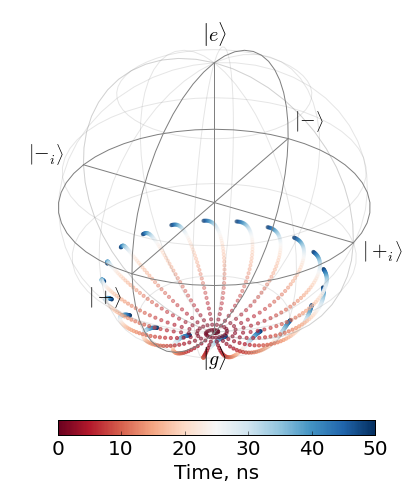

In [111]:
expects = np.array(result.expect)
nrm=matplotlib.colors.Normalize(0,Ts[-1])
colors=cm.RdBu(nrm(Ts))

fig = plt.figure(figsize=(7,7))
axes = fig.add_axes([0.1, 0.2, 0.8, 0.8], projection="3d")
sph = Bloch(fig=fig, axes=axes)
sph.sphere_alpha = 0
sph.zlabel = [r'$\left|e\rightangle\right.$', r"$\left|g\rightangle\right.$"]
sph.xlpos = [1.3, -1.3]
sph.xlabel = [r'$\left.|+\right\rangle$', r"$\left.|-\right\rangle$"]
sph.ylpos = [1.2, -1.3]
sph.ylabel = [r'$\left.|+_i\right\rangle$', r"$\left.|-_i\right\rangle$"]
sph.xlpos = [1.3, -1.3]
sph.point_size=[40]
# axes.view_init(elev=10)

sph.point_color = list(colors)
sph.point_marker=['.']
sph.add_points(expects[:, :], meth='m')
sph.render(fig, axes)
m = cm.ScalarMappable(cmap=cm.RdBu, norm=nrm)
m.set_array(Ts)
m.set_clim(0, Ts[-1])
position=fig.add_axes([0.2,0.15,0.63,0.03])
cb = fig.colorbar(m, orientation='horizontal', cax=position)
cb.set_label("Time, ns")
cb.set_ticks(np.linspace(0,round(Ts[-1]),6))

(-0.55, -0.57001)

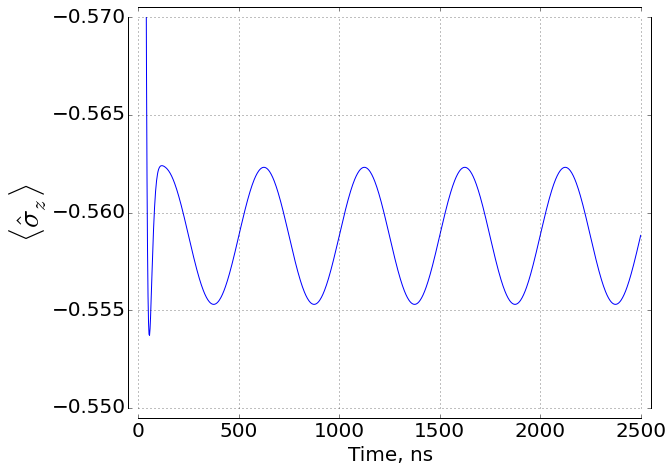

In [121]:
plt.plot(Ts,result.expect[2])
# plt.plot(Ts, np.sin(Ts)**2)
dict(plt.gca().spines.items())["left"].set_position(('outward', 10))
dict(plt.gca().spines.items())["bottom"].set_position(('outward', 10))
dict(plt.gca().spines.items())["top"].set_position(('outward', 10))
dict(plt.gca().spines.items())["right"].set_position(('outward', 10))

plt.gcf().set_size_inches(9,7)
plt.grid()
plt.xlabel("Time, ns")
plt.ylabel(r"$\langle\hat\sigma_z\rangle$", fontsize=30)
plt.ylim(-.55,-0.57001)

In [96]:
U = propagator([H,[A*sigmax(), 'np.sin(omega*t)']], 2*pi/omega_q, [np.sqrt(gamma_deph)*sigmam()],
                 args = {"omega":omega_q})

In [97]:
rho_s = propagator_steadystate(U)

In [102]:
expect(sigmaz(), rho_s)

-0.5588241069527555

In [99]:
gamma_deph*(sigmam()*rho_s*sigmam().dag() - 1/2*commutator(sigmam().dag()*sigmam(), rho_s, "anti"))

Quantum object: dims = [[2], [2]], shape = [2, 2], type = oper, isherm = True
Qobj data =
[[-0.02205879 +0.00000000e+00j -0.01755374 -1.40996980e-05j]
 [-0.01755374 +1.40996980e-05j  0.02205879 +0.00000000e+00j]]

In [100]:
commutator(sigmax(), rho_s)

Quantum object: dims = [[2], [2]], shape = [2, 2], type = oper, isherm = False
Qobj data =
[[ 0.00000000-0.00056399j  0.55882411+0.j        ]
 [-0.55882411+0.j          0.00000000+0.00056399j]]

In [101]:
commutator(H, rho_s)

Quantum object: dims = [[2], [2]], shape = [2, 2], type = oper, isherm = False
Qobj data =
[[ 0.0000000+0.j          2.2058686+0.00177182j]
 [-2.2058686+0.00177182j  0.0000000+0.j        ]]

In [101]:
from scipy import kron

In [113]:
sx = sigmax()
sx.data.

array([[ 0.+0.j,  1.+0.j],
       [ 1.+0.j,  0.+0.j]])

In [134]:
Qobj(kron(identity(2).data.toarray(), sigmay().data.toarray().T).dot(np.array([0,0,0,1])))

Quantum object: dims = [[4], [1]], shape = [4, 1], type = ket
Qobj data =
[[ 0.+0.j]
 [ 0.+0.j]
 [ 0.+1.j]
 [ 0.+0.j]]

In [133]:
Qobj([[0,0],[0,1]])*sigmay()

Quantum object: dims = [[2], [2]], shape = [2, 2], type = oper, isherm = False
Qobj data =
[[ 0.+0.j  0.+0.j]
 [ 0.+1.j  0.+0.j]]

# TMP